https://learn.qiskit.org/v1/course/ch-algorithms/defining-quantum-circuits

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble, converters
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

# importing Qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import I, X, Y, Z, H, CX, Zero, ListOp, PauliExpectation, PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki, PauliSumOp
from qiskit.circuit import Parameter

from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate
from qiskit.circuit.add_control import add_control
import qiskit.quantum_info as qi


In [2]:
import numpy as np
import scipy.linalg as la
des = [7/8, 3/8]
n = len(des)
s = np.diag(des)
q, _ = la.qr(np.random.rand(n, n))
A = q.T @ s @ q
eigs_h, vecs_h = np.linalg.eig(A)
RESULTS = []
# print(A)

In [3]:
# noise = np.random.normal(0,0.001,(2,2))/2
# noise = noise + noise.conj().T
# U = la.expm(1j*A)
# # U_noised = la.expm(1j*(A+noise))
# U_noise = la.expm(1j*(noise.T))
# U_noised = np.dot(U_noise, U)
# print(U)
# print(U_noised)
# print(np.dot(U, U_noise))

In [4]:
from sklearn.preprocessing import normalize
ERROR = 0.01
def add_noise_to_gate(U):
    noise = np.random.normal(0, ERROR, U.shape)/2
    noise = noise + noise.conj().T
    U_noise = la.expm(1j*(noise.T))
    U = np.dot(U_noise, U)
    return U

In [5]:
U = la.expm(1j*A)
eigs_u, vecs_u = np.linalg.eig(U)


In [6]:
n_of_qubs = 10
qpe = QuantumCircuit(n_of_qubs+1, n_of_qubs)
qpe.initialize(vecs_u[1], n_of_qubs)

In [7]:
# for i in range(100):
#     noise = np.random.normal(0, ERROR, U.shape)/2
#     print(noise)
# noise = noise + noise.conj().T
# U_noise = la.expm(1j*(noise.T))
# print(U_noise)

In [8]:
# for qubit in range(n_of_qubs):
import time
qpe_clear = QuantumCircuit(n_of_qubs+1)
for qubit in range(n_of_qubs):
    qpe_clear.h(qubit)
    
backend = Aer.get_backend('unitary_simulator')
job = execute(qpe_clear, backend)
result = job.result()
op = result.get_unitary(qpe_clear).data
op = add_noise_to_gate(op)
U_h = UnitaryGate(op)

qpe.append(U_h, range(n_of_qubs+1))    
# print(qpe)

In [9]:
gate = UnitaryGate(U).control(1)
repetitions = 1
qpe_clear = QuantumCircuit(n_of_qubs+1)
for i in range(0, n_of_qubs):
    for _ in range(repetitions):
        qpe_clear.append(gate,[i, n_of_qubs])
    repetitions *= 2
    
backend = Aer.get_backend('unitary_simulator')
job = execute(qpe_clear, backend)
result = job.result()
op = result.get_unitary(qpe_clear).data
op = add_noise_to_gate(op)
U_h = UnitaryGate(op)

qpe.append(U_h, range(n_of_qubs+1))

In [10]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [11]:
qpe.barrier()
# Apply inverse QFT
qpe_clear = QuantumCircuit(n_of_qubs+1)
qft_dagger(qpe_clear, n_of_qubs)
backend = Aer.get_backend('unitary_simulator')
job = execute(qpe_clear, backend)
result = job.result()
op = result.get_unitary(qpe_clear).data
op = add_noise_to_gate(op)
U_h = UnitaryGate(op)
qpe.append(U_h, range(n_of_qubs+1))
# Measure
qpe.barrier()
for n in range(n_of_qubs):
    qpe.measure(n,n)

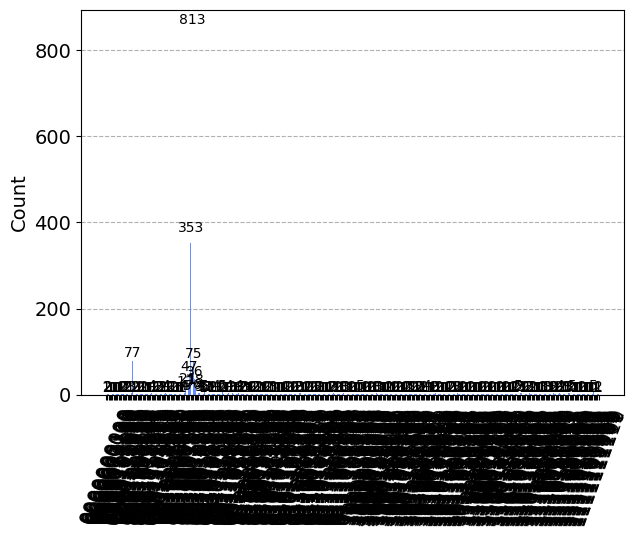

In [12]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
answer_to_plot = answer.copy()
answer = sorted(answer.items(), key=lambda x:x[1])
new_ans = []
for pair in answer:
    new_ans.append((int(pair[0],2), pair[1]))
answer = new_ans
plot_histogram(answer_to_plot)

In [72]:
# qpe.draw()

In [73]:
print(answer)

[(955, 1), (322, 1), (743, 1), (733, 1), (1005, 1), (837, 1), (391, 1), (40, 1), (602, 1), (578, 1), (763, 1), (726, 1), (154, 1), (330, 1), (533, 1), (1013, 1), (760, 1), (792, 1), (838, 1), (419, 1), (797, 1), (998, 1), (576, 1), (146, 1), (383, 1), (178, 1), (864, 1), (403, 1), (722, 1), (687, 1), (173, 1), (269, 1), (118, 1), (279, 1), (874, 1), (694, 1), (15, 1), (854, 1), (92, 1), (593, 1), (422, 1), (839, 1), (232, 1), (334, 1), (155, 1), (341, 1), (554, 1), (21, 1), (971, 1), (324, 1), (631, 1), (12, 1), (777, 1), (523, 1), (999, 1), (276, 1), (595, 1), (566, 1), (263, 1), (126, 1), (719, 1), (669, 1), (539, 1), (101, 1), (89, 1), (376, 1), (1015, 1), (833, 1), (451, 1), (150, 1), (22, 1), (156, 1), (799, 1), (931, 1), (368, 1), (189, 1), (5, 1), (392, 1), (1023, 1), (386, 1), (537, 1), (904, 1), (542, 1), (562, 1), (167, 1), (332, 1), (188, 1), (896, 1), (650, 1), (234, 1), (42, 1), (621, 1), (448, 1), (209, 1), (220, 1), (878, 1), (574, 1), (599, 1), (416, 1), (408, 1), (604,

In [74]:
import scipy.linalg as la
# print(la.expm(1j*4*np.pi*0/shots))
print(la.expm(1j*2*np.pi*61/(2**n_of_qubs)))

[[0.93076696+0.365613j]]


In [75]:
eigs_u

array([0.93050762+0.36627253j, 0.64099686+0.7675435j ])

# Answers sorting and plotting

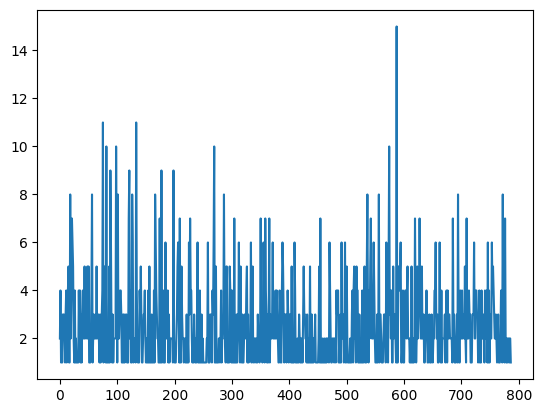

In [76]:
answer_copy = answer.copy()
answer_copy.sort(key=lambda x: x[0])
y = [val[1] for val in answer_copy]
x = [val[0] for val in answer_copy]
RESULTS.append((ERROR, x, y))
plt.plot(y)

In [77]:
# RESULTS.append((ERROR, histogram))

In [13]:
len(RESULTS)

0

# Results are already solved

In [23]:
import json
# Opening JSON file
f = open('2.json')
# returns JSON object as 
# a dictionary
data = json.load(f)
# print(data)
# Iterating through the json
# list
RESULTS = []
for key in data:
     RESULTS.append([key, data[str(key)]['x'], data[str(key)]['y']])

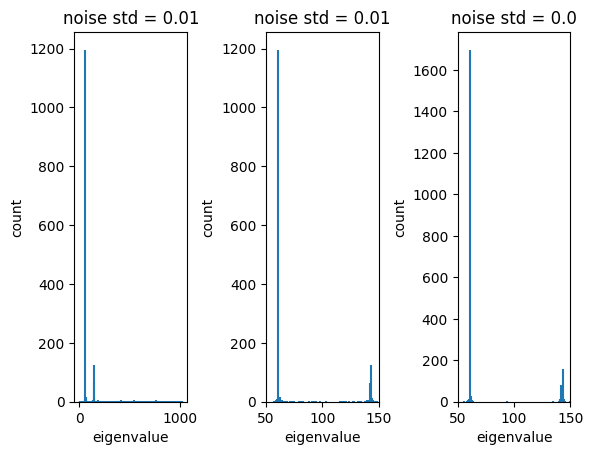

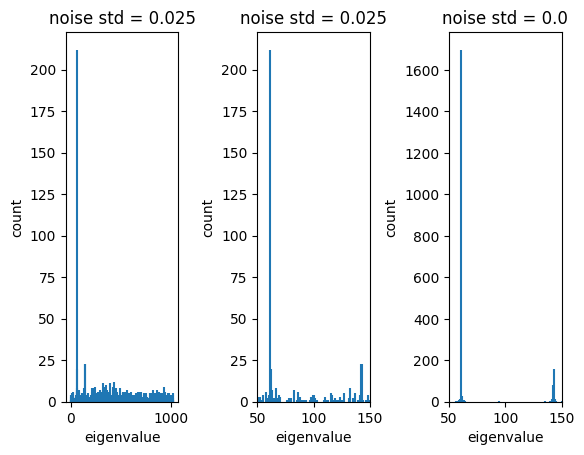

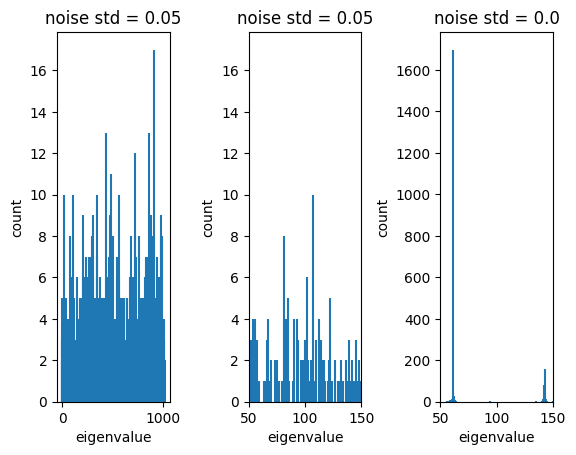

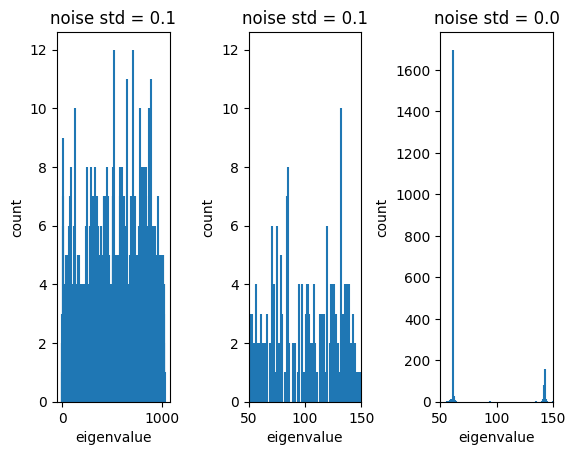

In [34]:
for tupple in RESULTS[1:]:
    fig = plt.figure()
    fig.subplots_adjust(hspace=1.7, wspace=0.7)
    plt.subplot(1, 3, 1)
    # plt.plot(tupple[1], tupple[2])
    plt.vlines(tupple[1],0,tupple[2])
    plt.title(f'noise std = {tupple[0]}')
    plt.xlabel('eigenvalue')
    plt.ylabel('count')
    plt.ylim(0)
    
    plt.subplot(1, 3, 2)
    # plt.plot(tupple[1], tupple[2])
    plt.vlines(tupple[1],0,tupple[2])
    plt.title(f'noise std = {tupple[0]}')
    plt.xlim(50, 150)
    plt.xlabel('eigenvalue')
    plt.ylabel('count')
    plt.ylim(0)
    
    plt.subplot(1, 3, 3)
    plt.vlines(RESULTS[0][1],0,RESULTS[0][2])
    plt.title(f'noise std = {RESULTS[0][0]}')
    plt.xlim(50, 150)
    plt.xlabel('eigenvalue')
    plt.ylabel('count')
    plt.ylim(0)
    
    plt.show()

In [46]:
# plt.plot(tupple[1], tupple[2])
# plt.title(f'noise std = {tupple[0]}')
# plt.plot(RESULTS[0][1], RESULTS[0][2])
# plt.title(f'noise std = {RESULTS[0][0]}')
# plt.show()

# In JSON format

In [100]:
result = {}
for tupple in RESULTS:
    result[tupple[0]] = {
        'x': tupple[1],
        'y': tupple[2]
    }

In [101]:
# import json

# # Serialize data into file:
# json.dump( result, open( "2.json", 'w' ) )